In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets, fixed
from e_com import (
    gen_product_id,
    get_cost_price,
    filter_outliers,
    get_outliers,
    cluster_outliers,
)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

In [3]:
df = pd.read_csv('Sample-Superstore.csv', encoding='ISO-8859-1')

In [4]:
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"] = pd.to_datetime(df["Ship Date"])

In [5]:
df = gen_product_id(get_cost_price(df))

In [6]:
color = ['#ff9e03', 'g', 'b', 'r', '#ffb300']

In [7]:
sns.set_theme()
sns.set_style('darkgrid')
sns.set(rc={
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'axes.titlepad': 10,
    'xtick.labelsize': 10,
    'xtick.color': 'grey',
    'ytick.labelsize': 10,
    'ytick.color': 'grey',
    'axes.titlecolor': 'black',
    "figure.dpi":100, 
    'savefig.dpi':200,
    }) 

In [8]:
def k_cluster_analysis(data, show_scores):
    ssd = []

    range_n_clusters = np.arange(2, 10)
    max_score = 0
    optimal_n_clusters = 0
    for num_clusters in range_n_clusters:
        kmeans = KMeans(
            n_clusters=num_clusters, max_iter=50, n_init="auto", random_state=420
        )
        kmeans.fit(data)
        # Elbow-curve /SSD
        ssd.append(kmeans.inertia_)

        cluster_labels = kmeans.labels_
        # silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        if silhouette_avg > max_score:
            max_score = silhouette_avg
            optimal_n_clusters = num_clusters
        if show_scores:
            print(
                "For n_clusters={0}, the silhouette score is {1}".format(
                    num_clusters, silhouette_avg
                )
            )

    if show_scores:
        # plot the SSDs for each n_clusters
        fig, ax = plt.subplots(figsize=(5, 5))
        sns.lineplot(ssd, ax=ax)
    return optimal_n_clusters

In [9]:
def k_clustering(dataframe, remove_outliers = True, show_plots = False):

    # Make a copy of a dataframe
    data = dataframe.copy()
    # Determine the number of columns in the dataframe
    features = data.columns[1:]
    b = len(features)
    
    if show_plots:
        # Plot the features
        fig, ax = plt.subplots(1, b, figsize=(b*4, 4))
        for i, col in enumerate(features):
            sns.boxplot(data=data[col], ax=ax[i], color=color[i])
            ax[i].set_xlabel(col)
        plt.tight_layout()
    
    if remove_outliers:
        for col in features:
            # Removing outliers
            data[col] = filter_outliers(data[col])
        data.dropna(inplace=True)
    if show_plots:    
        # Plot the features with removed outliers        
        fig, ax = plt.subplots(1, b, figsize=(b*4, 4))
        for i, col in enumerate(features):
            sns.boxplot(data=data[col], ax=ax[i], color=color[i])
            ax[i].set_xlabel(col)
        ax[1].set_title("Outliers Removed")
        plt.tight_layout()
        
        # Remove the rows where ouliers were
        

    # Scale the data with StandartScaler
    scaled_data = StandardScaler().fit_transform(data[data.columns[1:]])
    scaled_data = pd.DataFrame(scaled_data)
    scaled_data.columns = data.columns[1:]

    # Initiate k-means and find the k with the highest silhouette score
    kmeans = KMeans(
        n_clusters=k_cluster_analysis(scaled_data, show_scores=False), max_iter=50, n_init="auto"
    )
    kmeans.fit(scaled_data)

    # Assign the labels to each data point, and execute the following script.
    kmeans.labels_
    label_list = kmeans.labels_
    print(sorted(Counter(label_list).items()))

    # Assign the label
    data["Cluster ID"] = kmeans.labels_

    fig, ax = plt.subplots(1, b, figsize=(b*4, 4))

    for i, col in enumerate(features):
        sns.boxplot(x="Cluster ID", y=col, data=data, ax=ax[i])
        ax[i].set_xlabel("Cluster")
    plt.tight_layout()

    return data


In [10]:
state_orders = df.groupby('State', as_index=False)['Order ID'].count()
state_sales = df.groupby('State', as_index=False)['Sales'].sum()
sdf = pd.merge(state_orders, state_sales, on='State')
sdf.rename(columns={'Order ID': 'Orders'}, inplace=True)

[(0, 30), (1, 12)]


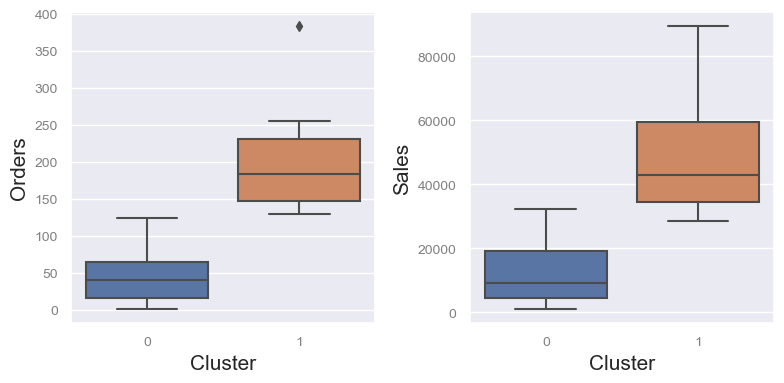

In [11]:
state_clusters = k_clustering(sdf, True, False)

<Axes: xlabel='Orders', ylabel='Sales'>

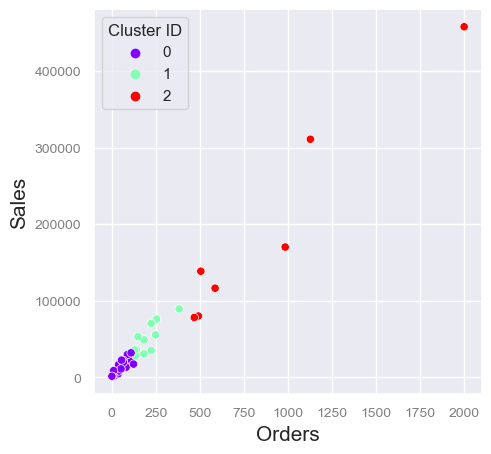

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=cluster_outliers(get_outliers(sdf), state_clusters), x='Orders', y='Sales', hue='Cluster ID', palette='rainbow')

In [13]:
customer_orders = df.groupby("Customer ID", as_index=False)["Order ID"].count()
customer_sales = df.groupby("Customer ID", as_index=False)["Sales"].sum()
customer_last_order = df.groupby("Customer ID", as_index=False)["Order Date"].max()
customer_last_order["Recency"] = (
    df["Order Date"].max() - customer_last_order["Order Date"]
).dt.days
cdf = pd.merge(customer_orders, customer_sales, on='Customer ID')
cdf = pd.merge(cdf, customer_last_order, on='Customer ID').drop('Order Date', axis=1)
cdf.rename(columns={'Order ID': 'Frequency', 'Sales': 'Sales Amount'}, inplace=True)
cdf

,Customer ID,Frequency,Sales Amount,Recency
0,AA-10315,11,5563.560,184
1,AA-10375,15,1056.390,19
2,AA-10480,12,1790.512,259
3,AA-10645,18,5086.935,55
4,AB-10015,6,886.156,415
...,...,...,...,...
788,XP-21865,28,2374.658,43
789,YC-21895,8,5454.350,4
790,YS-21880,12,6720.444,9
791,ZC-21910,31,8025.707,54


[(0, 265), (1, 297), (2, 103)]


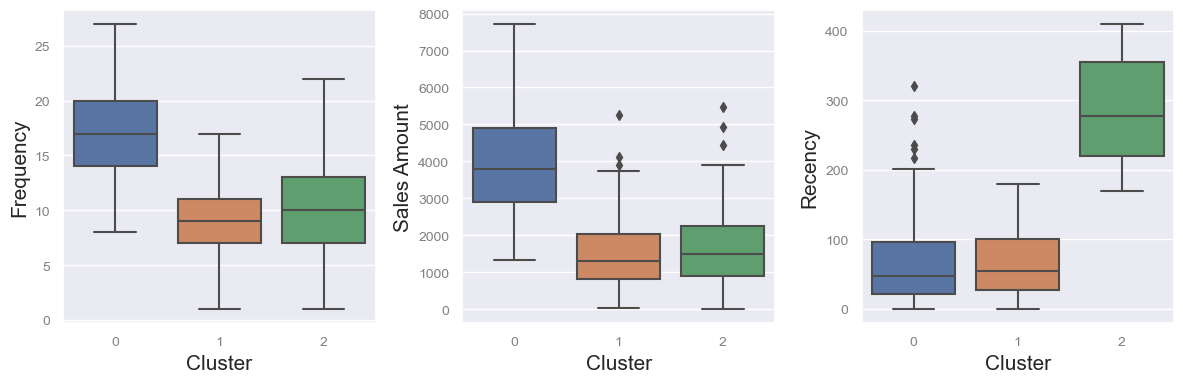

In [14]:
customer_clusters = k_clustering(cdf)

In [15]:
c_clusters = cluster_outliers(get_outliers(cdf), customer_clusters)

In [16]:
def get_xyz(data):
    x = data.iloc[:, 3]
    y = data.iloc[:, 1]
    z = data.iloc[:, 2]
    c = data.iloc[:, -1]
    return (x, y, z, c)

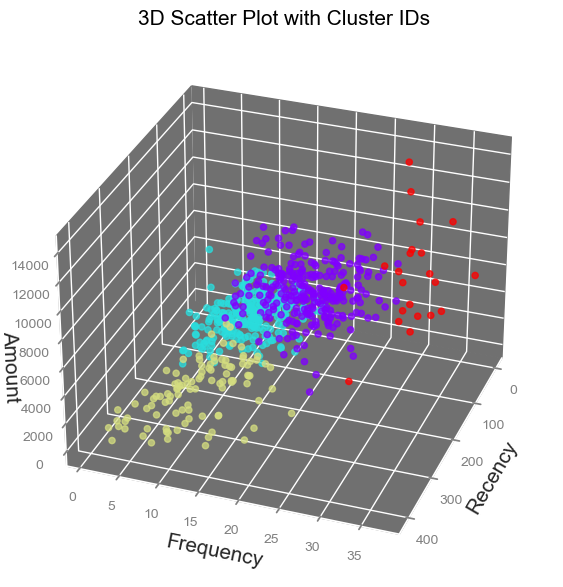

In [17]:
def plot_3d(clustered_data):
    fig = plt.figure(figsize=(7, 7))
    fig.set_facecolor('#ffffff')

    # defining all 3 axis
    xyzc = get_xyz(clustered_data)

    # syntax for 3-D projection
    ax = plt.axes(projection ='3d')
    ax.set_facecolor('#ffffff')
    ax.scatter3D(xyzc[0], xyzc[1], xyzc[2], c=xyzc[3], cmap='rainbow', alpha=0.75)
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Amount', labelpad=1)
    ax.set_title('3D Scatter Plot with Cluster IDs')
    ax.xaxis.set_pane_color('#707070')
    ax.yaxis.set_pane_color('#707070')
    ax.zaxis.set_pane_color('#707070')
    ax.view_init(30, 20)

    plt.show()

plot_3d(c_clusters)

In [18]:
def update_plot(elev, azim, clustered_data, label):
    fig = plt.figure(figsize=(7, 7))
    ax = plt.axes(projection ='3d')
    ax.set_facecolor('#ffffff')
    xyzc = get_xyz(clustered_data)
    scatter_plot = ax.scatter3D(xyzc[0], xyzc[1], xyzc[2], c=xyzc[3], cmap='rainbow', alpha=0.8)
    ax.set_xlabel(xyzc[0].name)
    ax.set_ylabel(xyzc[1].name)
    ax.set_zlabel(xyzc[2].name, labelpad=2)
    ax.set_title(f'{label} Clusters')
    ax.xaxis.set_pane_color('#707070')
    ax.yaxis.set_pane_color('#707070')
    ax.zaxis.set_pane_color('#707070')
    legend_labels = sorted(xyzc[-1].unique())
    ax.legend(*[scatter_plot.legend_elements()[0],legend_labels], 
                    title="Clusters", loc='upper left')
    ax.view_init(elev=elev, azim=azim)
    plt.show()

def interact_3d_plot(data, label):
    elevation_slider = widgets.IntSlider(value=30, min=0, max=89, description='Elevation')
    azimuth_slider = widgets.IntSlider(value=30, min=0, max=89, description='Azimuth')
    interact(update_plot, elev=elevation_slider, azim=azimuth_slider, clustered_data=fixed(data), label=fixed(label))

interact_3d_plot(c_clusters, 'Customer')

interactive(children=(IntSlider(value=30, description='Elevation', max=89), IntSlider(value=30, description='A…

In [19]:
df["Delivery Time"] = (df["Ship Date"] - df["Order Date"]).dt.days
product_sales = df.groupby("Product ID", as_index=False)["Sales"].sum()
product_orders = df.groupby("Product ID", as_index=False)["Quantity"].sum()
product_del_time = (
    df.groupby("Product ID", as_index=False)["Delivery Time"].mean().round(2)
)
pdf = pd.merge(product_sales, product_orders, on='Product ID')
pdf = pd.merge(pdf, product_del_time, on='Product ID')
pdf

,Product ID,Sales,Quantity,Delivery Time
0,FUR-BO-10000112,825.174,9,2.00
1,FUR-BO-10000330,1064.624,10,1.67
2,FUR-BO-10000362,2154.348,14,4.00
3,FUR-BO-10000468,723.842,21,3.67
4,FUR-BO-10000711,851.760,12,6.50
...,...,...,...,...
1857,TEC-PH-10004912,516.530,11,3.33
1858,TEC-PH-10004922,1085.238,19,4.00
1859,TEC-PH-10004924,56.164,8,2.33
1860,TEC-PH-10004959,341.666,4,3.00


[(0, 431), (1, 518), (2, 227), (3, 403)]


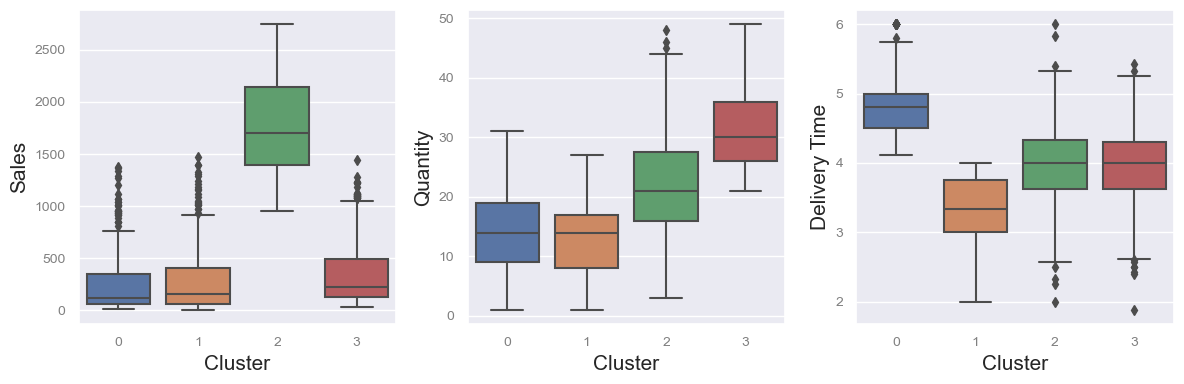

In [20]:
product_clusters = k_clustering(pdf, True, False)

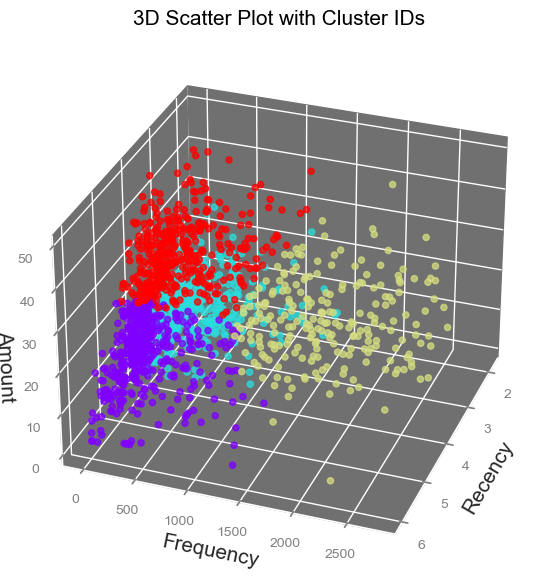

In [21]:
plot_3d(product_clusters)

In [22]:
p_outliers = get_outliers(pdf).sort_values(by='Sales', ascending=False)[100:]
p_clusters = cluster_outliers(p_outliers, product_clusters)

In [23]:
interact_3d_plot(p_clusters, 'Products with Outliers')

interactive(children=(IntSlider(value=30, description='Elevation', max=89), IntSlider(value=30, description='A…

In [24]:
order_items = df[df['Category'] == 'Technology'].groupby('Order ID')['Product Name'].apply(list).to_list()[:20]

In [25]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
te = TransactionEncoder()
te_try = te.fit(order_items).transform(order_items)
tdf = pd.DataFrame(te_try, columns=te.columns_)
frequent_itemsets = apriori(tdf, min_support=0.00001, use_colnames=True, verbose=1)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
# frequent_itemsets[frequent_itemsets['length'] > 1].sort_values(by='support', ascending=False)
association_rules = association_rules(frequent_itemsets, metric="confidence")
association_rules

Processing 6 combinations | Sampling itemset size 3 2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Motorola Droid Maxx),(Cisco 8x8 Inc. 6753i IP Business Phone System),0.05,0.05,0.05,1.0,20.0,0.0475,inf,1.0
1,(Cisco 8x8 Inc. 6753i IP Business Phone System),(Motorola Droid Maxx),0.05,0.05,0.05,1.0,20.0,0.0475,inf,1.0
2,(Rosewill 107 Normal Keys USB Wired Standard K...,(Polycom SoundPoint IP 450 VoIP phone),0.05,0.05,0.05,1.0,20.0,0.0475,inf,1.0
3,(Polycom SoundPoint IP 450 VoIP phone),(Rosewill 107 Normal Keys USB Wired Standard K...,0.05,0.05,0.05,1.0,20.0,0.0475,inf,1.0


In [26]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# for i, col in enumerate(kdf.columns[1:]):
#     sns.boxplot(data=kdf[col], ax=ax[i], color=color[i])
#     ax[i].set_xlabel(col)

# ax[1].set_title('Customer Features')


# fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# for i, col in enumerate(kdf.columns[1:]):
#     sns.boxplot(data=filter_outliers(kdf[col]), ax=ax[i], color=color[i])
#     ax[i].set_xlabel(col)

# # Removing the outliers 

# for col in kdf.columns[1:]:
#     kdf[col] = filter_outliers(kdf[col])
#     # kdf[kdf[col].isna()] = kdf[col].max()

# kdf.dropna(inplace=True)

# # Instantiate
# scaler = StandardScaler()

# # fit_transform
# scaled_kdf = scaler.fit_transform(kdf[['Amount', 'Frequency', 'Recency']])
# scaled_kdf.shape

# scaled_kdf = pd.DataFrame(scaled_kdf)
# scaled_kdf.columns = ['Amount', 'Frequency', 'Recency']
# scaled_kdf.head()

# # k-means with some arbitrary k
# kmeans = KMeans(n_clusters=4, max_iter=50, n_init='auto')
# kmeans.fit(scaled_kdf)

# # Assign the labels to each data point, and execute the following script.
# kmeans.labels_
# label_list=kmeans.labels_
# sorted(Counter(label_list).items())

# k_cluster_analysis(scaled_kdf)

# kmeans = KMeans(n_clusters=3, max_iter=50, n_init='auto')
# kmeans.fit(scaled_kdf)

# # Assign the label
# kdf['Cluster ID'] = kmeans.labels_
# kdf.head()

# fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# for i, col in enumerate(kdf.columns[1:4]):
#     sns.boxplot(x='Cluster ID', y=col, data=kdf, ax=ax[i])
#     ax[i].set_xlabel(col)
# plt.tight_layout()

# fig, ax = plt.subplots(figsize=(8, 6))
# sns.scatterplot(data=kdf, x='Recency', y='Amount', hue='Cluster ID', palette='tab10')